In [1]:
from model import Network
from data import load_mnist_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt 

# Batch size - 4

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_mnist_instance.json'
checkpoint_path = './checkpoints/122123_fc1_cocktail_party_mnist_pretraining_wout_bias.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
normalize_mean, normalize_std = (0.1307,), (0.3081,)
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

_, val_dataloader = load_mnist_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

In [13]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 784])]


In [14]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T

In [15]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True)
reconstruction_loss = ReconstructImageFromFCLoss(28, 28, 1, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 1.7799906730651855
loss: 0.8018211126327515
loss: 0.7917412519454956
loss: 0.7816375494003296
loss: 0.7746265530586243
loss: 0.770200252532959
loss: 0.7671310901641846
loss: 0.7648475170135498
loss: 0.7632502913475037
loss: 0.7618112564086914
loss: 0.7613334059715271
loss: 0.7601088285446167
loss: 0.7589117884635925
loss: 0.7585625052452087
loss: 0.757926344871521
loss: 0.7575494647026062
loss: 0.75761479139328
loss: 0.7573052644729614
loss: 0.7572897672653198
loss: 0.7571158409118652
loss: 0.7570361495018005
loss: 0.7569063901901245
loss: 0.7565951943397522
loss: 0.7569130063056946
loss: 0.7561760544776917
loss: 0.7565310597419739


## Estimated images

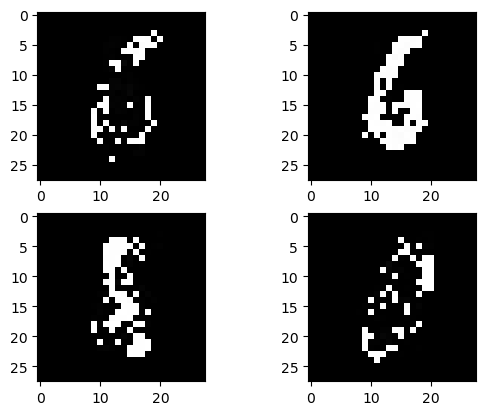

In [25]:
with torch.no_grad():
    estimated_img = unmixing_matrix @ whitened_gradient
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()

## Original images

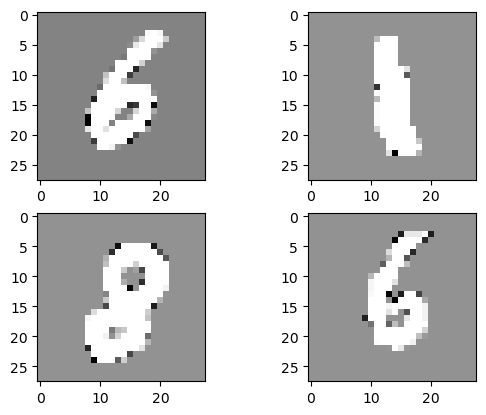

In [26]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()

# Batch size - 8

In [29]:
batch_size = 8
_, val_dataloader = load_mnist_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

In [30]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 784])]


In [31]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T

In [32]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True)
reconstruction_loss = ReconstructImageFromFCLoss(28, 28, 1, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 1.9031039476394653
loss: 0.9232221245765686
loss: 0.9144185781478882
loss: 0.9067055583000183
loss: 0.9005805850028992
loss: 0.8955019116401672
loss: 0.8918029069900513
loss: 0.8889302611351013
loss: 0.8863770365715027
loss: 0.8847690224647522
loss: 0.8835135102272034
loss: 0.882746696472168
loss: 0.8820927143096924
loss: 0.8822293877601624
loss: 0.8813639879226685
loss: 0.881512463092804
loss: 0.8808542490005493
loss: 0.8806993961334229
loss: 0.8809231519699097
loss: 0.880926251411438
loss: 0.8803148865699768
loss: 0.8806453347206116
loss: 0.8801682591438293
loss: 0.8813499212265015
loss: 0.8803877234458923
loss: 0.8804993629455566


## Estimated images

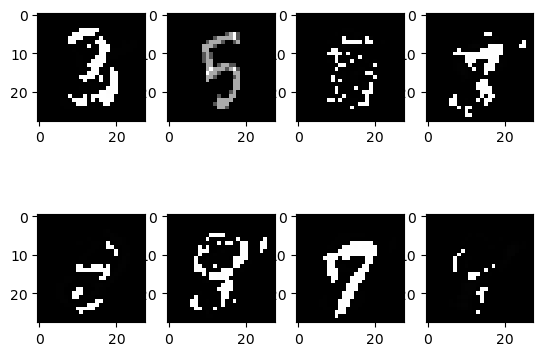

In [34]:
with torch.no_grad():
    estimated_img = unmixing_matrix @ whitened_gradient
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()

## Original images

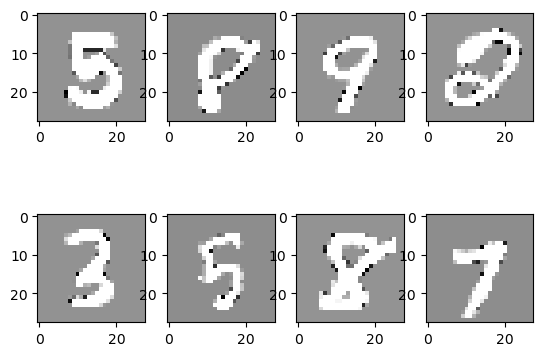

In [35]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()

# Batch size - 16

In [3]:
batch_size = 16
_, val_dataloader = load_mnist_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([10, 784])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(28, 28, 1, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.0742111206054688
loss: 1.11597740650177
loss: 1.06015944480896
loss: 1.047412633895874
loss: 1.040440559387207
loss: 1.035456657409668
loss: 1.0319297313690186
loss: 1.0293954610824585
loss: 1.0278126001358032
loss: 1.026733160018921
loss: 1.0262304544448853
loss: 1.0258203744888306
loss: 1.025679588317871
loss: 1.024971842765808
loss: 1.0250566005706787
loss: 1.025080680847168
loss: 1.0249325037002563
loss: 1.0251448154449463
loss: 1.0244313478469849
loss: 1.024501085281372
loss: 1.0246225595474243
loss: 1.024986982345581
loss: 1.0249770879745483
loss: 1.024780035018921
loss: 1.0244537591934204
loss: 1.024797797203064


## Estimated images

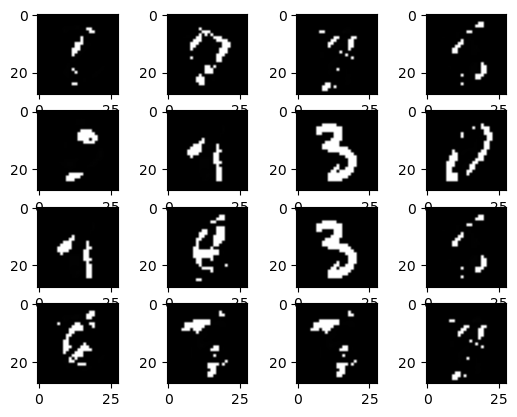

In [8]:
unmixing_matrix = unmixing_matrix.detach()
with torch.no_grad():
    estimated_img = unmixing_matrix @ whitened_gradient
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()

## Original images

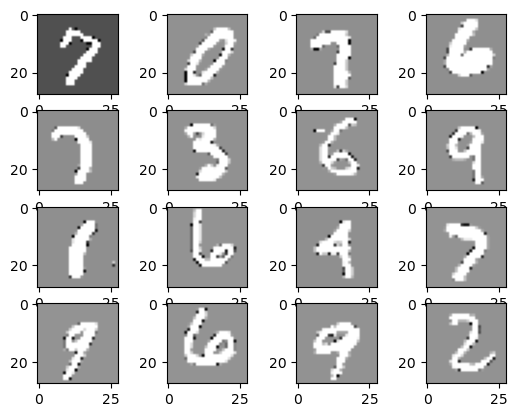

In [9]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(28, 28), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()